In [1]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# DML、DRL、Tree based Models

## Get Data

In [3]:
import pandas as pd
df = pd.read_csv('data/causal_test_data_u.csv')

In [4]:
print(df[['Y','T','W1','W2','W3','X1','X2']].describe())

                 Y            T          W1           W2           W3  \
count  5000.000000  5000.000000  5000.00000  5000.000000  5000.000000   
mean      2.096447     0.485200     0.48860     0.997600     0.001087   
std       1.524565     0.499831     0.49992     0.815676     1.007699   
min      -2.143872     0.000000     0.00000     0.000000    -3.697959   
25%       1.056835     0.000000     0.00000     0.000000    -0.672679   
50%       2.041039     0.000000     0.00000     1.000000    -0.001744   
75%       2.964149     1.000000     1.00000     2.000000     0.683607   
max      12.786778     1.000000     1.00000     2.000000     3.445319   

                X1           X2  
count  5000.000000  5000.000000  
mean      1.008400     0.002017  
std       0.813426     1.003394  
min       0.000000    -3.841058  
25%       0.000000    -0.652245  
50%       1.000000    -0.005002  
75%       2.000000     0.666014  
max       2.000000     3.324141  


In [5]:
df.dtypes

Unnamed: 0      int64
U             float64
X1              int64
X2            float64
W1              int64
W2              int64
W3            float64
T               int64
true_HTE      float64
HTE           float64
Y             float64
dtype: object

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.6, test_size=0.4)
Y = train['Y']
T = train['T']
X = train[['X1','X2','W1','W2','W3']]

X_test = test[['X1','X2','W1','W2','W3']]

## Base Models

In [7]:
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from econml.sklearn_extensions.linear_model import WeightedLasso

def first_stage_reg():
    return GridSearchCVList([Lasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             GradientBoostingRegressor(random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                               {'max_depth': [3, None],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def first_stage_clf():
    return GridSearchCVList([LogisticRegression(),
                             RandomForestClassifier(n_estimators=100, random_state=123),
                             GradientBoostingClassifier(random_state=123)],
                             param_grid_list=[{'C': [0.01, .1, 1, 10, 100]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'n_estimators': [50, 100],
                                               'max_depth': [3],
                                               'min_samples_leaf': [10, 30]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

def final_stage():
    return GridSearchCVList([WeightedLasso(),
                             RandomForestRegressor(n_estimators=100, random_state=123)],
                             param_grid_list=[{'alpha': [.001, .01, .1, 1, 10]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]}],
                             cv=5,
                             scoring='neg_mean_squared_error')

In [8]:
model_y = clone(first_stage_reg().fit(X, Y).best_estimator_)
model_y

GradientBoostingRegressor(min_samples_leaf=30, random_state=123)

In [9]:
model_t = clone(first_stage_clf().fit(X, T).best_estimator_)
model_t

LogisticRegression(C=0.1)

## DML Models

In [10]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

n_samples, n_features = X.shape
subsample_fr_ = (n_samples/2)**(1-1/(2*n_features+2))/(n_samples/2)
est = CausalForestDML(model_y=model_y,
                      model_t=model_t,
                      discrete_treatment=True,
                      cv=3,
                      n_estimators=4000,
                      random_state=123)
est.tune(Y, T, X=X).fit(Y, T, X=X, cache_values=True)

In [11]:
from econml.dml import NonParamDML
est2 = NonParamDML(model_y=model_y,
                   model_t=model_t,
                   cv=3,
                   discrete_treatment=True,
                   model_final=final_stage())
est2.fit(Y, T, X=X)

In [12]:
# CausalForestDML的预测结果
pred = est.effect(X_test)
# lb, ub = est.effect_interval(X, alpha=0.05)

In [13]:
# non param DML 的预测结果
pred2 = est2.effect(X_test)

In [14]:
df_res = test.copy(deep=True)
df_res['forestdml'] = pred
df_res['nonparamdml'] = pred2

<AxesSubplot:xlabel='X1'>

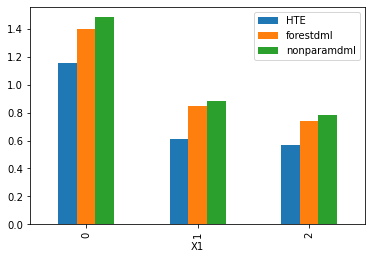

In [15]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','forestdml','nonparamdml'], kind='bar')

<AxesSubplot:xlabel='W1'>

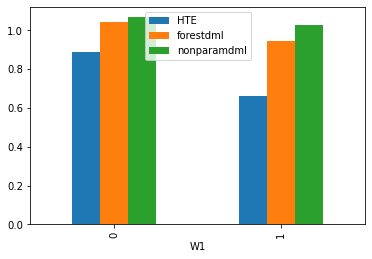

In [16]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','forestdml','nonparamdml'], kind='bar')

<AxesSubplot:xlabel='W3'>

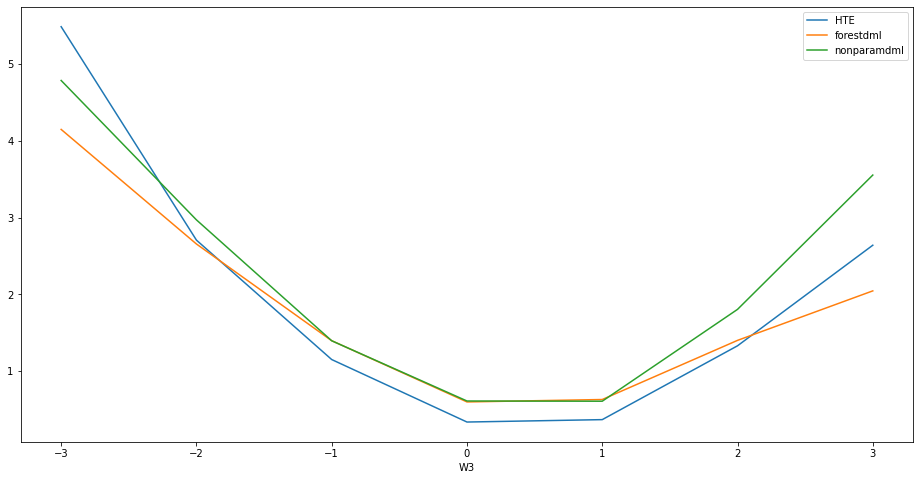

In [17]:
tmp = df_res.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','forestdml','nonparamdml'], kind='line',figsize=(16,8))

## DRL Models

In [18]:
# DRL:利用T、X的信息估计Y
model_regression = clone(first_stage_reg().fit(np.hstack([T.values.reshape(-1, 1), X]), Y).best_estimator_)
model_regression

GradientBoostingRegressor(min_samples_leaf=10, random_state=123)

In [19]:
from econml.dr import ForestDRLearner
from sklearn.dummy import DummyRegressor, DummyClassifier

est = ForestDRLearner(model_regression=model_y,
                      model_propensity=model_t,
                      cv=3,
                      n_estimators=4000,
                      min_samples_leaf=10,
                      verbose=0,
                      min_weight_fraction_leaf=.005)
est.fit(Y, T, X=X)

In [20]:
from econml.dr import DRLearner
est2 = DRLearner(model_regression=model_y,
                 model_propensity=model_t,
                 model_final=final_stage(),
                 cv=3)
est2.fit(Y, T.values.reshape((-1, 1)), X=X)

In [21]:
pred = est.effect(X_test)
pred2 = est2.effect(X_test)

In [22]:
df_res['forestdrl'] = pred
df_res['nonparamdrl'] = pred2

<AxesSubplot:xlabel='X1'>

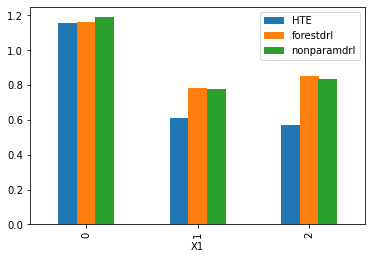

In [23]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','forestdrl','nonparamdrl'], kind='bar')

<AxesSubplot:xlabel='W1'>

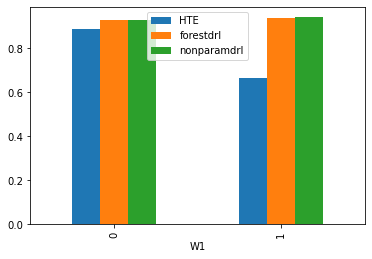

In [24]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','forestdrl','nonparamdrl'], kind='bar')

<AxesSubplot:xlabel='W3'>

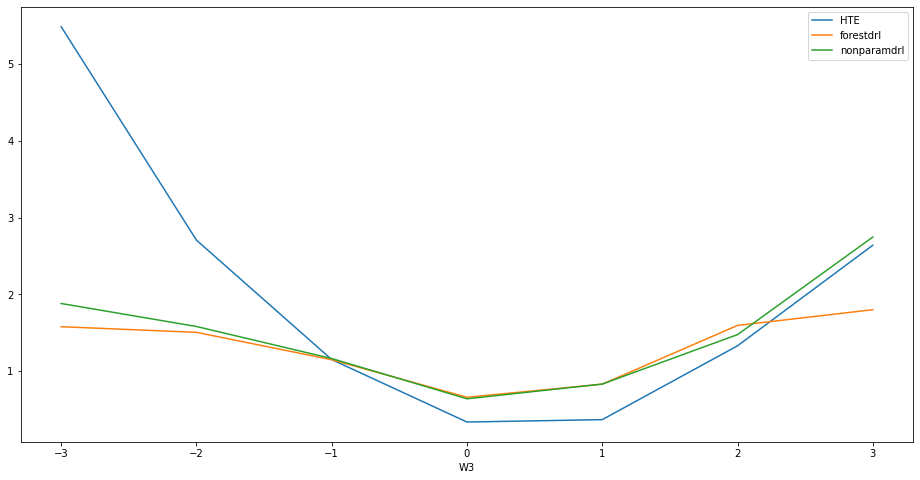

In [25]:
tmp = df_res.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','forestdrl','nonparamdrl'], kind='line',figsize=(16,8))

## DROrthoForest -Failed

In [26]:
# from econml.orf import DROrthoForest
# from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
# from econml.sklearn_extensions.linear_model import WeightedLassoCV

# est3 = DROrthoForest(model_Y=Lasso(alpha=0.01),
#                      propensity_model=LogisticRegression(C=1),
#                      model_Y_final=WeightedLassoCV(cv=3),
#                      propensity_model_final=LogisticRegressionCV(cv=3),
#                      n_trees=1000, min_leaf_size=10)
# est3.fit(Y, T, X=X)
# pred3 = est3.effect(X)

## GRF

In [27]:
from econml.grf import CausalForest
est = CausalForest(criterion='het', n_estimators=400, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)
est.fit(X, T, Y)
est_grf = est.predict(X_test)

df_res['grf'] = est_grf

## Summary of results

In [28]:
df_summary = df_res.copy(deep = True)

<AxesSubplot:xlabel='X1'>

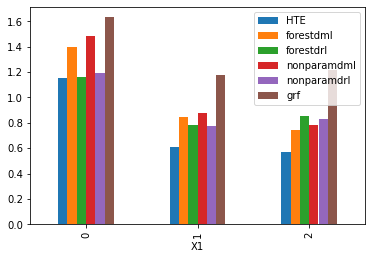

In [29]:
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','forestdml','forestdrl','nonparamdml','nonparamdrl','grf'], kind='bar')

<AxesSubplot:xlabel='W1'>

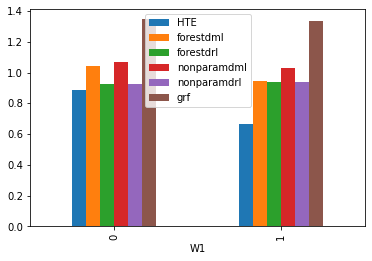

In [30]:
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','forestdml','forestdrl','nonparamdml','nonparamdrl','grf'], kind='bar')

<AxesSubplot:xlabel='W3'>

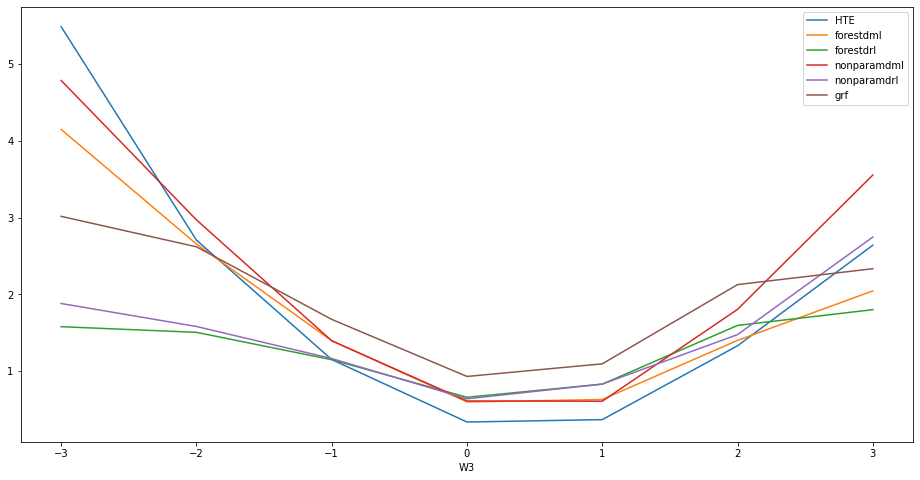

In [31]:
tmp = df_summary.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','forestdml','forestdrl','nonparamdml','nonparamdrl','grf'], kind='line',figsize=(16,8))

# meta-Learners

In [32]:
# Main imports
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner

# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

%matplotlib inline

## Get Data

In [33]:
n = train.shape[0]

## Train Models

In [34]:
# Instantiate T learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
T_learner = TLearner(models=models)
# Train T_learner
T_learner.fit(Y, T, X=X)
# Estimate treatment effects on test data
T_te = T_learner.effect(X_test)

In [35]:
# Instantiate S learner
overall_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
S_learner = SLearner(overall_model=overall_model)
# Train S_learner
S_learner.fit(Y, T, X=X)
# Estimate treatment effects on test data
S_te = S_learner.effect(X_test)

In [36]:
# Instantiate X learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(n/100))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(n/100))
X_learner = XLearner(models=models, propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y, T, X=X)
# Estimate treatment effects on test data
X_te = X_learner.effect(X_test)

## Results Comparation

In [37]:
df_res[['T-learner','S-learner','X-learner']] = np.stack([T_te, S_te, X_te],axis=1)

<AxesSubplot:xlabel='X1'>

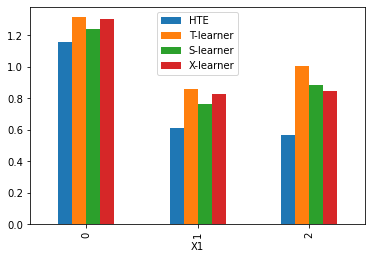

In [38]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='X1',y=['HTE','T-learner','S-learner','X-learner'], kind='bar')

<AxesSubplot:xlabel='W1'>

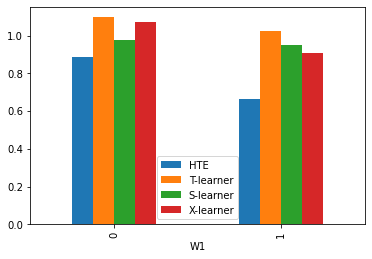

In [39]:
tmp = df_res.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
tmp.plot(x='W1',y=['HTE','T-learner','S-learner','X-learner'], kind='bar')

<AxesSubplot:xlabel='W3'>

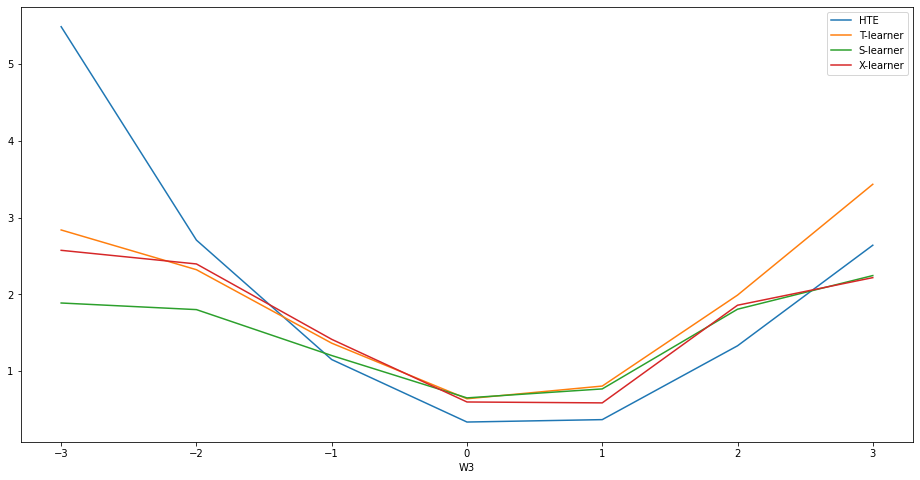

In [40]:
tmp = df_res.copy(deep=True)
tmp['W3'] = tmp['W3'].apply(lambda x : round(x,0))
tmp = tmp.groupby('W3').mean()
tmp.reset_index(inplace=True)
tmp.sort_values('W3').plot(x='W3',y=['HTE','T-learner','S-learner','X-learner'], kind='line',figsize=(16,8))

# Summary of Above Models

In [41]:
y_list = ['HTE','forestdml','forestdrl','grf','nonparamdml','nonparamdrl','T-learner','S-learner','X-learner']
df_summary = df_res.copy(deep=True)

## Comparation of HTE

In [ ]:
import numpy as np	# 加载数学库用于函数描述
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

matplotlib.rcParams['text.usetex'] = False # 开启Latex风格
plt.figure(figsize=(150, 200), dpi=140)  # 设置图像大小
style.use('ggplot')  # 加载'ggplot'风格
# f, ax = plt.subplots(2, 3)  # 设置子图

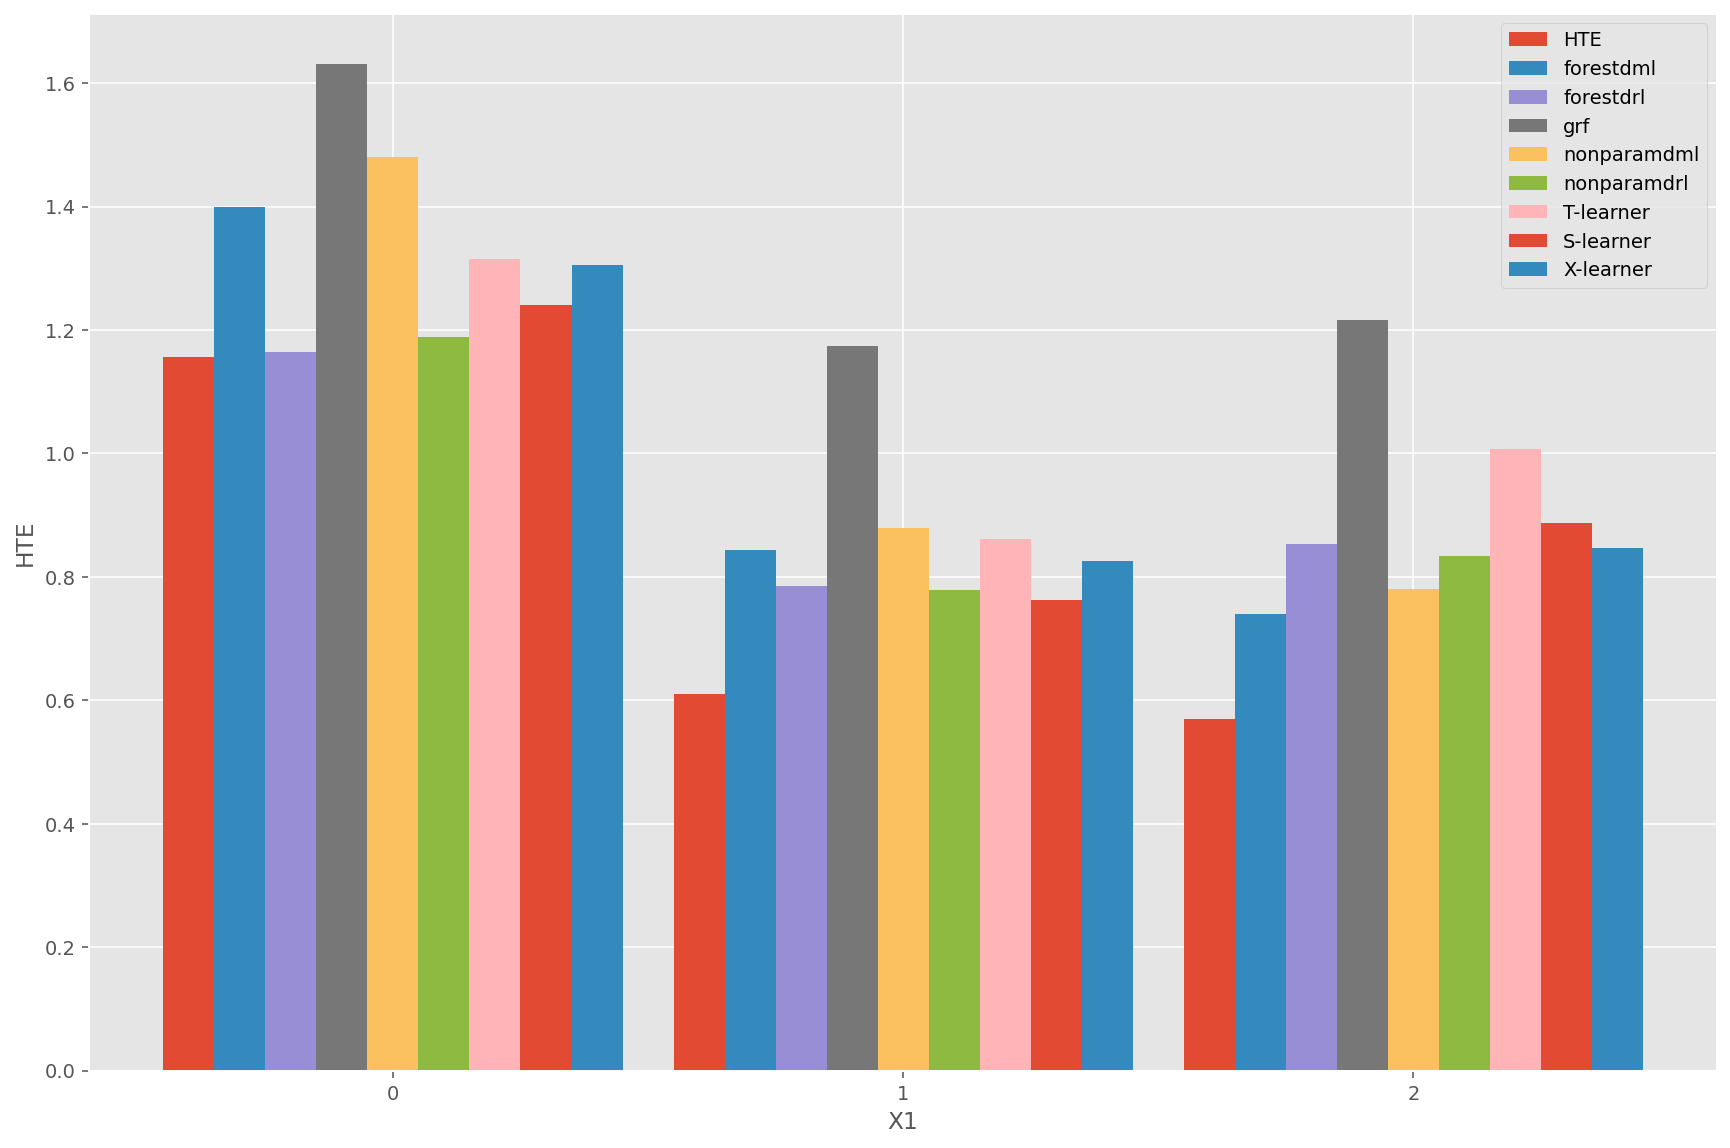

In [101]:
plt.figure(figsize=(15, 10), dpi=140)
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('X1').mean()
tmp.reset_index(inplace=True)
i = -1
for col in y_list:
    i +=0.2
    plt.bar(tmp['X1']+i/2,tmp[col],label=col,width=0.1)
plt.legend(loc='upper right')
plt.xticks([0,1,2])
plt.xlabel('X1')
plt.ylabel('HTE')
plt.show()
# tmp.plot(x='X1',y=y_list, kind='bar',figsize=(16,8))

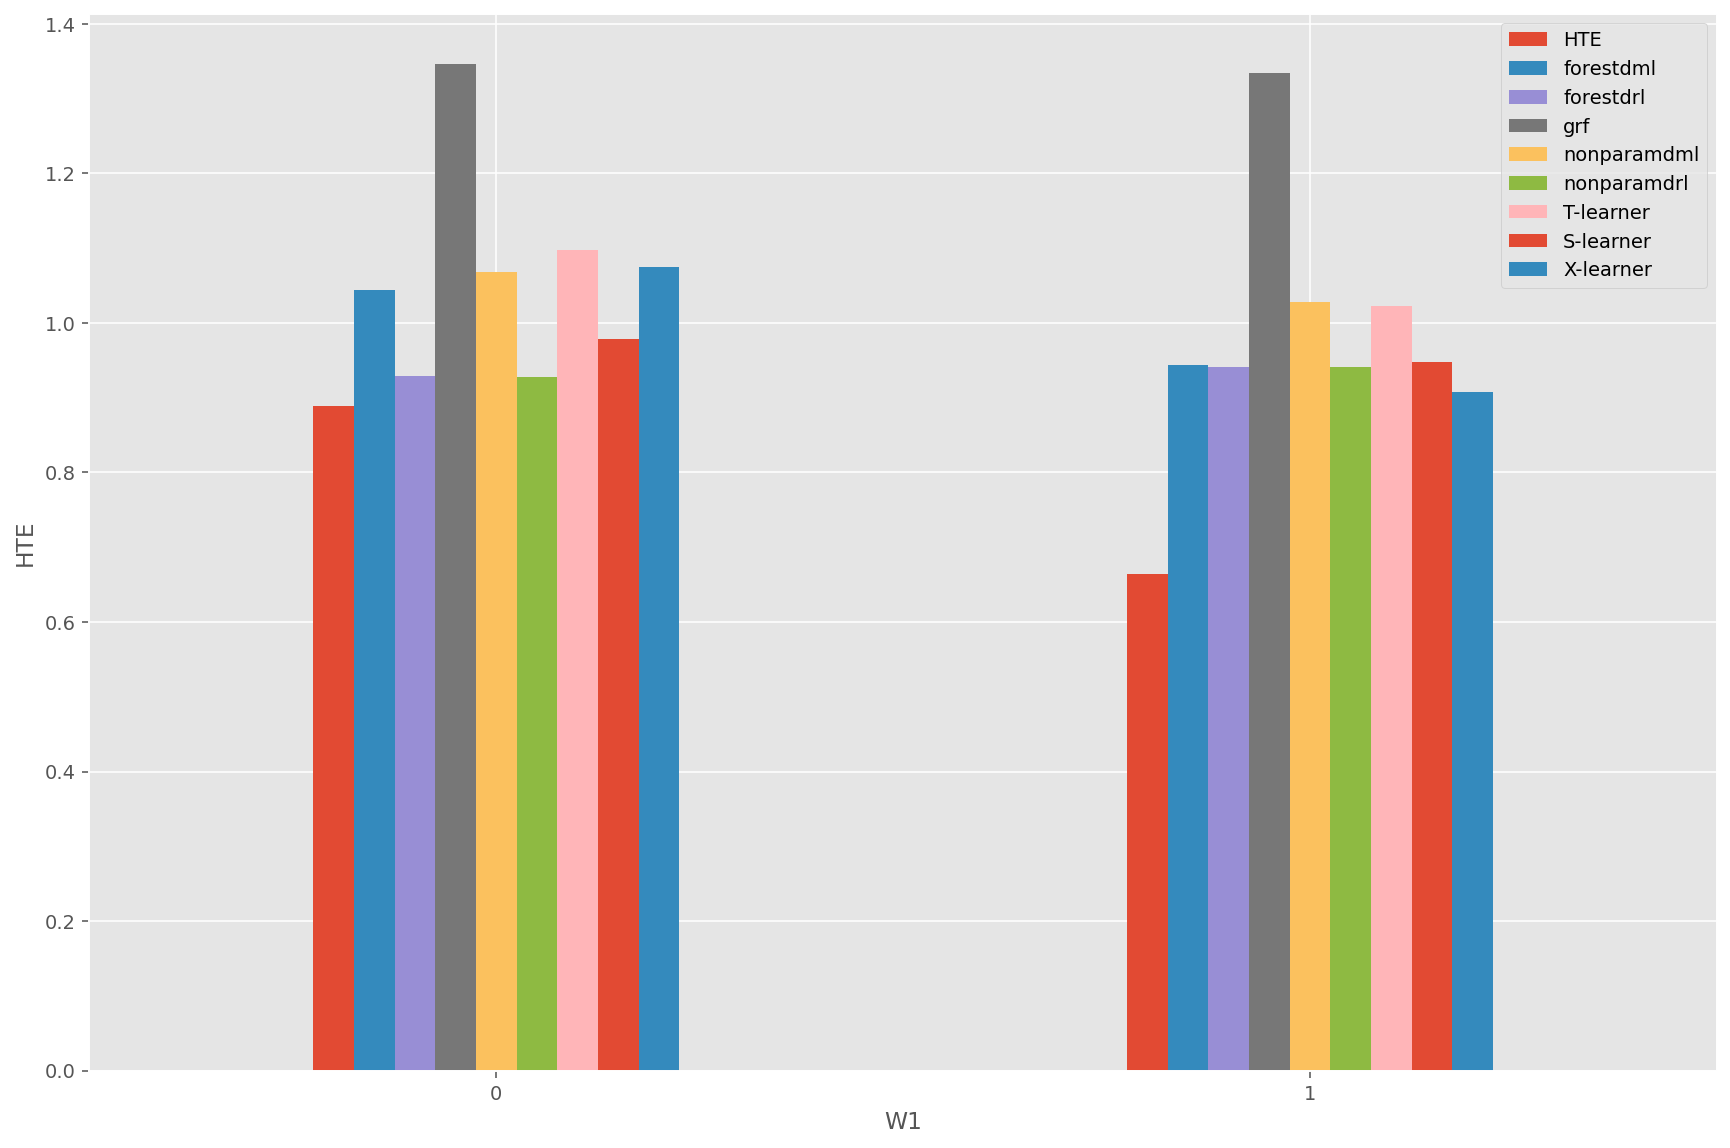

In [98]:
plt.figure(figsize=(15, 10), dpi=140)
tmp = df_summary.copy(deep=True)
tmp = tmp.groupby('W1').mean()
tmp.reset_index(inplace=True)
i = -1
for col in y_list:
    i +=0.2
    plt.bar(tmp['W1']+i/4,tmp[col],label=col,width=0.05)
plt.legend(loc='upper right')
plt.xlim(-0.5,1.5)
plt.xticks([0,1])
plt.xlabel('W1')
plt.ylabel('HTE')
plt.show()
# tmp.plot(x='X1',y=y_list, kind='bar',figsize=(16,8))

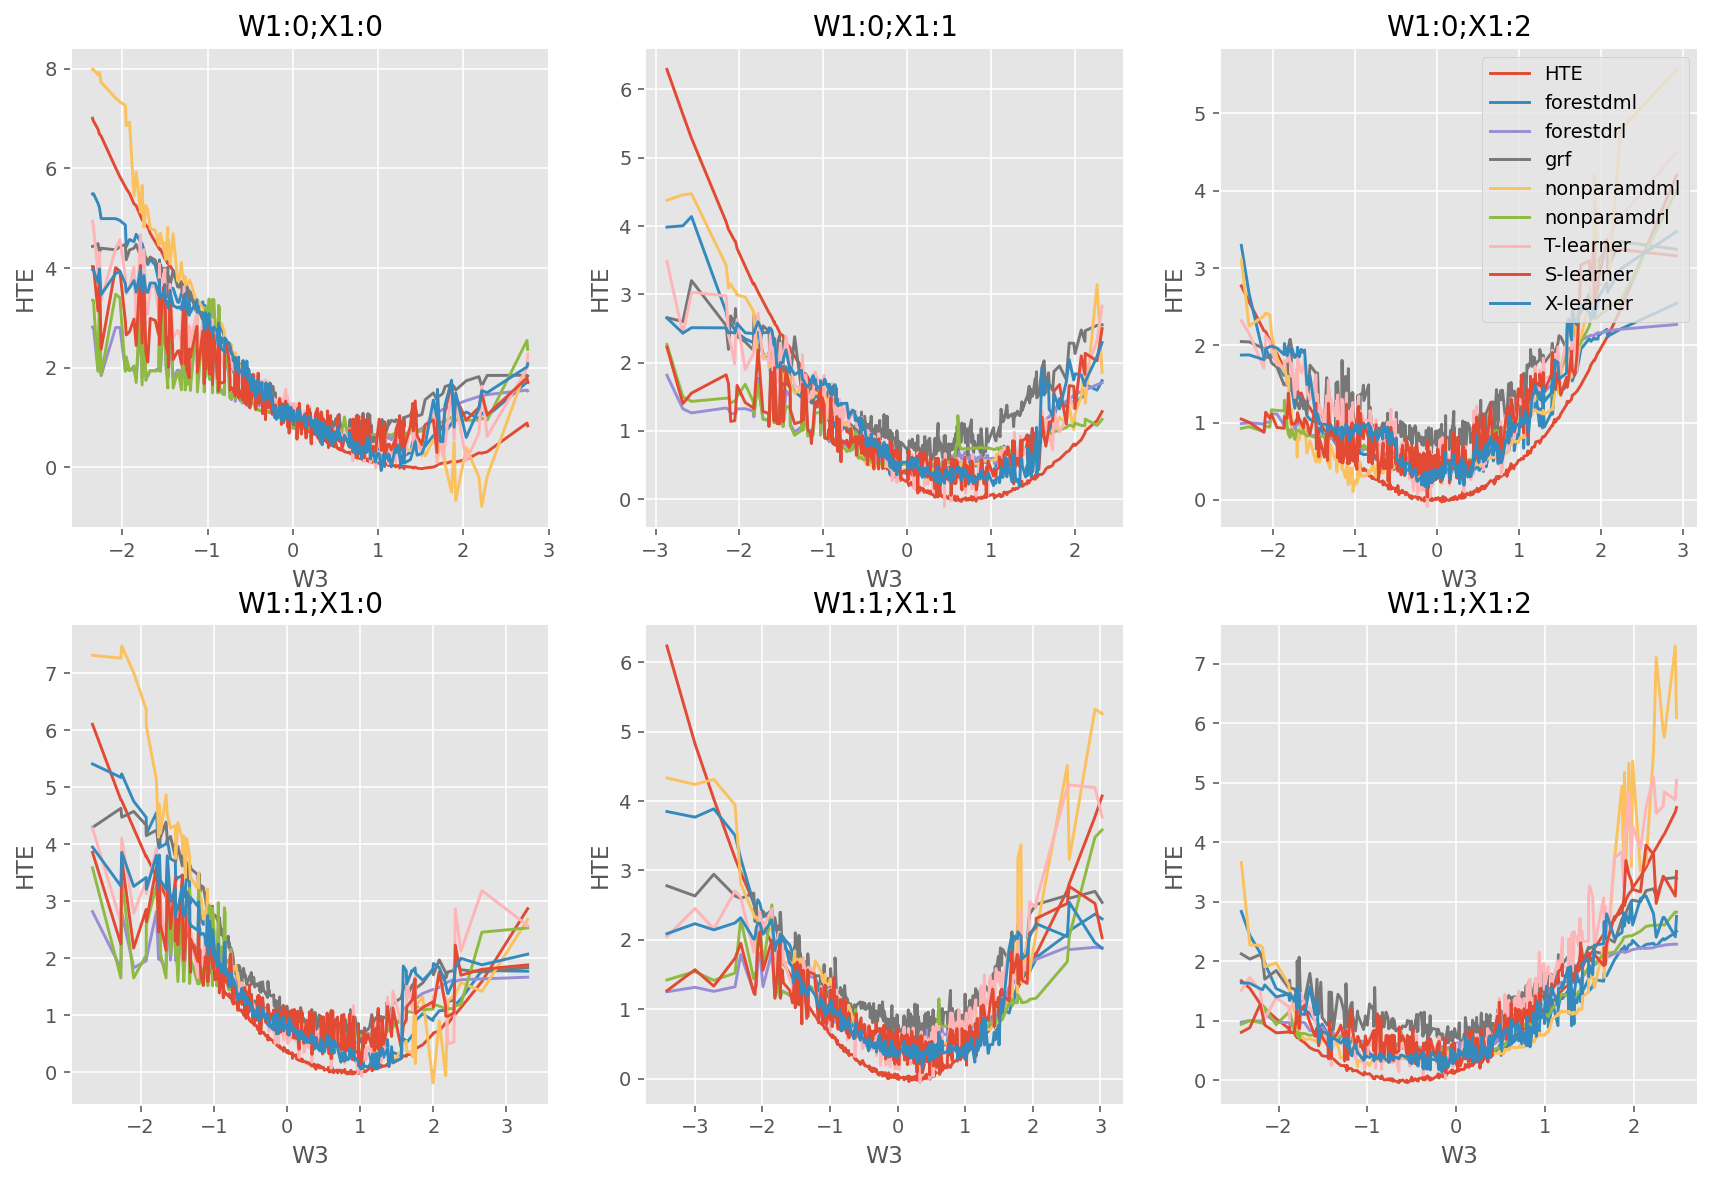

In [84]:
plt.figure(figsize=(15, 10), dpi=140)
i = 0
for w in [0,1]:
    for x in [0,1,2]:
        i += 1
        tmp = df_summary[(df_summary['W1'] == w)&(df_summary['X1'] == x)].copy(deep=True)
        tmp = tmp.sort_values('W3')
        for col in y_list:
            ax = plt.subplot(2, 3, i)
            ax.plot(tmp['W3'], tmp[col], label=col)
            if i == 3:
                plt.legend(loc='upper right')
            plt.title('W1:%d;X1:%d' % (w,x))
            plt.xlabel('W3')
            plt.ylabel('HTE')
plt.show()

## Comparation with Scores

In [45]:
# MSE, MAE, R2, RMSE
import numpy as np
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score#R 2
#调用
# mean_squared_error(y_test,y_predict)
# mean_absolute_error(y_test,y_predict)
# np.sqrt(mean_squared_error(y_test,y_predict))  # RMSE就是对MSE开方即可
# r2_score(y_test,y_predict)

In [46]:
score_df = pd.DataFrame({'model':[],'MSE':[],'MAE':[],'R2':[],'RMSE':[]})
for col in y_list:
    if col == 'HTE': continue
    mse = mean_squared_error(y_true=df_res['HTE'], y_pred=df_res[col])
    mae = mean_absolute_error(y_true=df_res['HTE'], y_pred=df_res[col])
    r2 = r2_score(y_true=df_res['HTE'], y_pred=df_res[col])
    score_df = score_df.append({'model':col, 'MSE':mse, 'MAE':mae, 'R2':r2, 'RMSE':(mse ** 0.5)},
                               ignore_index=True)
score_df = score_df.sort_values('MSE')
score_df

,model,MSE,MAE,R2,RMSE
0,forestdml,0.177328,0.340382,0.838734,0.421103
7,X-learner,0.237100,0.355234,0.784376,0.486929
3,nonparamdml,0.242543,0.382169,0.779425,0.492487
5,T-learner,0.281612,0.411665,0.743895,0.530671
6,S-learner,0.393433,0.453468,0.642203,0.627242
4,nonparamdrl,0.475611,0.506480,0.567468,0.689645
1,forestdrl,0.498813,0.504849,0.546367,0.706267
2,grf,0.560541,0.658084,0.490230,0.748693


In [47]:
print(score_df)

         model       MSE       MAE        R2      RMSE
0    forestdml  0.177328  0.340382  0.838734  0.421103
7    X-learner  0.237100  0.355234  0.784376  0.486929
3  nonparamdml  0.242543  0.382169  0.779425  0.492487
5    T-learner  0.281612  0.411665  0.743895  0.530671
6    S-learner  0.393433  0.453468  0.642203  0.627242
4  nonparamdrl  0.475611  0.506480  0.567468  0.689645
1    forestdrl  0.498813  0.504849  0.546367  0.706267
2          grf  0.560541  0.658084  0.490230  0.748693


<AxesSubplot:xlabel='model'>

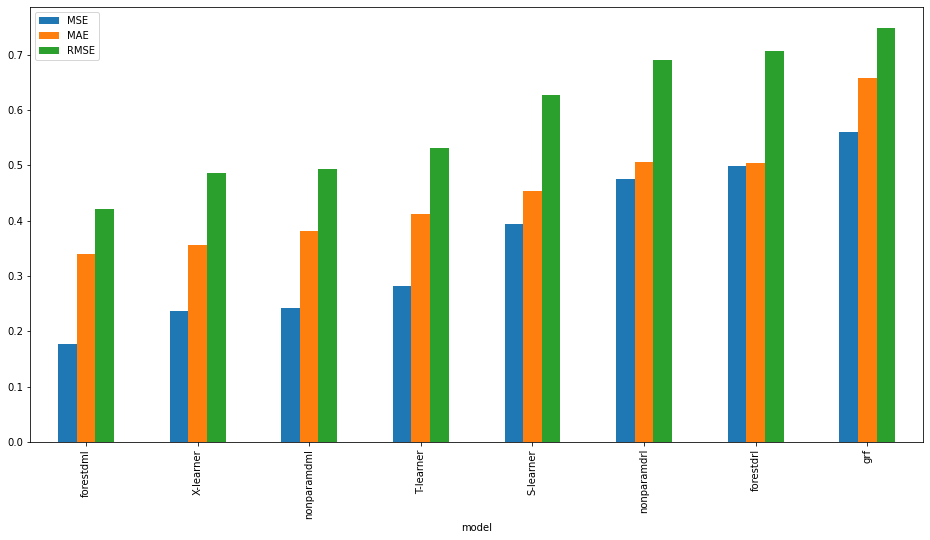

In [50]:
score_df.plot(kind='bar',x='model',y=['MSE', 'MAE', 'RMSE'], figsize=(16,8))

<AxesSubplot:xlabel='model'>

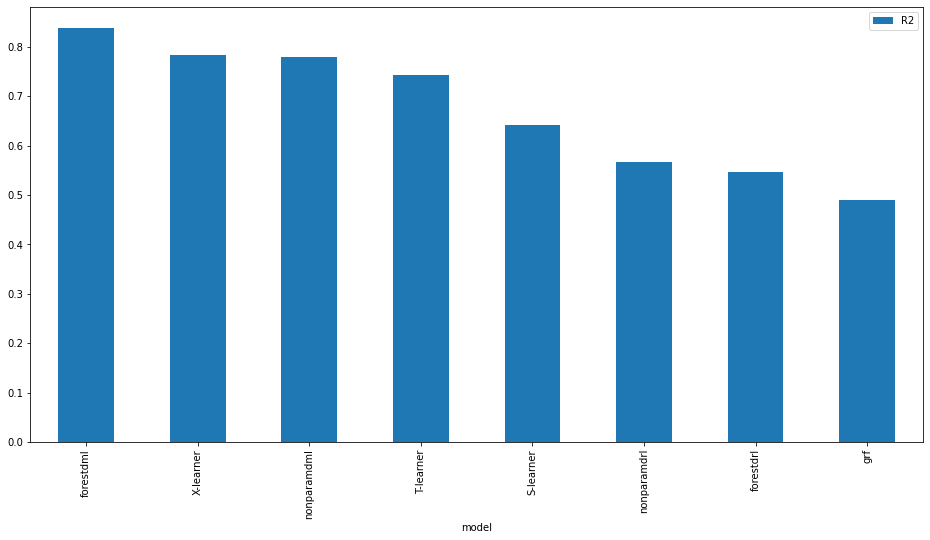

In [51]:
score_df.plot(kind='bar',x='model',y=['R2'], figsize=(16,8))